In [1]:
%load_ext autoreload
%autoreload 2

# Device selection

In [2]:
from cobos.tokens import ibm_token, group_instance, group_instance2
from qiskit_ibm_runtime import QiskitRuntimeService

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_brisbane"
device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

first_layout_qubit = 83
eplg_absolute = 1.63e-3

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance2)
backend = service.backend(device)

# Auxiliary lattice plot

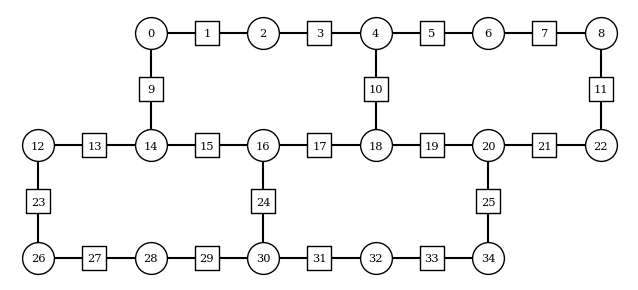

In [3]:
from z2hex.geometry import HeavyHexLattice

plaquette_width = 2
plaquette_height = 2

HeavyHexLattice(plaquette_width, plaquette_height).plot_lattice(number_qubits=True)

# Simulation settings

In [4]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

lattice_dims_arr = [(2, 2)]
J_arr = [1]
h_arr = [0.8]
lamb_arr = [0.3]
g_arr = [8]

x_basis = False

# strings_arr = [[6, 7, 8, 16, 26, 25, 24, 34, 43, 44, 45, 54, 64, 63, 62, 72, 81, 82, 83, 92, 102, 101, 100]]
strings_arr = [[4, 10, 18, 17, 16, 24, 30]]

final_time = 5
steps = 35

shots = [75000]

execution_database = "z2_hex_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

# Circuit generation & observables

In [5]:
from z2hex.operators import local_pauli_x, local_pauli_z, postselection_operators
from z2hex.circs import get_erradj_string_quench_simulation_circuits
from utils.circs import generate_and_save_circs
from z2hex.geometry import HeavyHexLattice
from functools import partial
from itertools import product
import os

optimization_level = 3

circuits = [] # circuits[dims][Jhλg][t]
observable_generating_funcs = [] # observable_generating_funcs[dims][i]
postselection_operators_funcs = [] # postselection_operators_funcs[dims][i]
extra_options = [] # extra_options[dims][Jhλg]

sampler_options = [{
    "default_shots": nshots,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
} for nshots in shots]

for (px, py), string_arr in zip(lattice_dims_arr, strings_arr):
    this_circuits = []
    this_extra_options = []
    lattice = HeavyHexLattice(px, py)
    for J, h, lamb, g in product(J_arr, h_arr, lamb_arr, g_arr):
        circuits_filepath = os.path.join(circ_folder_path, f"z2hex_string_quench_circs_{device}_px_{px}_py_{py}_maxt_{final_time}_steps_{steps}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_fqb_{first_layout_qubit}_string_{"-".join([str(i) for i in string_arr])}_xbasis_{x_basis}.qpy")
        circs_args = (lattice, J, h, lamb, string_arr, final_time, steps, backend, optimization_level, eplg_absolute, g, first_layout_qubit, x_basis, False)
        physical_circuits = generate_and_save_circs(circuits_filepath, get_erradj_string_quench_simulation_circuits, *circs_args)
        this_circuits.append(physical_circuits)
        this_extra_options.append({"backend": device, "plaquette_width": px, "plaquette_height": py, "J": J, "h": h, "λ":lamb, "g": g, "string_arr": string_arr, "final_time": final_time, "eplg": eplg_absolute})
    circuits.append(this_circuits)
    observable_generating_funcs.append([(lambda nqubits, i=i: local_pauli_x(lattice, i) if x_basis else local_pauli_z(lattice, i)) for i in range(len(lattice))])
    postselection_operators_funcs.append(lambda nqubits: postselection_operators(lattice, x_basis))
    extra_options.append(this_extra_options)

# circuits[0][0][1].draw(output="mpl", idle_wires=False)

# Post-selected circuit execution

### Send jobs to hardware

In [6]:
from utils.postselection import execute_postselected_sampler_batch
from itertools import product

jobs = [] # jobs[dims][Jhλg][t]

for i, (px, py) in enumerate(lattice_dims_arr):
    this_dims_jobs = []
    for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
        params_ind = gi + lambi*len(g_arr) + hi*len(g_arr)*len(lamb_arr) + Ji*len(g_arr)*len(lamb_arr)*len(h_arr)
        this_jobs = execute_postselected_sampler_batch(backend, sampler_options[i], circuits[i][params_ind], postselection_operators_funcs[i], observable_generating_funcs[i], extra_options=extra_options[i][params_ind], job_db=job_db)
        this_dims_jobs.append(this_jobs)
    jobs.append(this_dims_jobs)

### Load jobs with the same options

In [6]:
from utils.postselection import load_postselected_jobs
from itertools import product

jobs = [] # jobs[dims][Jhλg][t]
samples_dicts = [] # samples_dicts[dims][Jhλg][t]
postselected_samples_dicts = [] # postselected_samples_dicts[dims][Jhλg][t]

for i, (px, py) in enumerate(lattice_dims_arr):
    this_dims_jobs = []
    this_dims_samples_dicts = []
    this_dims_postselected_samples_dicts = []
    for j, (Ji, hi, lambi, gi) in enumerate(product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr)))):
        clean_extra_options = extra_options[i][j].copy()
        del clean_extra_options["eplg"]
        this_jobs, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, sampler_options[i], circuits[i][j], postselection_operators_funcs[i], observable_generating_funcs[i], clean_extra_options, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True)
        this_dims_jobs.append(this_jobs)
        this_dims_samples_dicts.append(this_samples_dicts)
        this_dims_postselected_samples_dicts.append(this_samples_dicts)
    jobs.append(this_dims_jobs)
    samples_dicts.append(this_dims_samples_dicts)
    postselected_samples_dicts.append(this_dims_postselected_samples_dicts)

# Plots

In [7]:
from z2hex.plotting import local_obs_anim

interpolation_frames = 17
fps = 30
frame_to_title_func = lambda frame: f"$t = {final_time * frame / ((interpolation_frames+1)*steps):.02f}$"

for i, (px, py) in enumerate(lattice_dims_arr):
    for j, (Ji, Hi, lambi, gi) in enumerate(product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr)))):
        this_occupations = (1 - jobs[i][j])/2
        local_obs_anim(this_occupations, lattice, frame_to_title_func, interpolation_frames=interpolation_frames, fps=fps, filepath=f"z2hex_string_quench_{device}_postselection_maxt_{final_time:.02f}_steps_{steps}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_fqb_{first_layout_qubit}_string_{"-".join([str(i) for i in string_arr])}_xbasis_{x_basis}.mp4")

TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [10]:
jobs[0][0][0]

array([ 0.1106 , -0.3316 ,  0.10204, -0.28148,  0.03756, -0.2614 ,
        0.0802 , -0.27248, -0.05052, -0.39548,  0.09584, -0.2402 ,
        0.09664, -0.25468,  0.2522 , -0.37328, -0.39188,  0.03128,
       -0.12988, -0.03244, -0.37428, -0.05984, -0.32552,  0.0308 ,
        0.051  ,  0.02948, -0.3496 , -0.04784, -0.34096, -0.0534 ,
       -0.3794 ,  0.15936, -0.1906 , -0.33164,  0.13792, -0.3684 ,
        0.07656, -0.34324, -0.0462 , -0.3566 , -0.04696, -0.29632,
        0.05836,  0.01604,  0.04444, -0.3812 , -0.059  , -0.35364,
       -0.05468, -0.40024,  0.16464, -0.34444,  0.13136, -0.37456,
       -0.38976,  0.1184 , -0.33636, -0.03812, -0.2318 ,  0.02556,
        0.1182 ,  0.02204, -0.3284 , -0.04304, -0.3778 , -0.05584,
       -0.39596, -0.04648, -0.32528,  0.14096, -0.33004,  0.05092,
       -0.25516, -0.36868,  0.12568, -0.37084,  0.11892, -0.28704,
        0.01088,  0.24532, -0.09756, -0.30608, -0.0248 , -0.32316,
        0.12884, -0.38   ,  0.15068])

ValueError: 'c' argument has 87 elements, which is inconsistent with 'x' and 'y' with size 1.

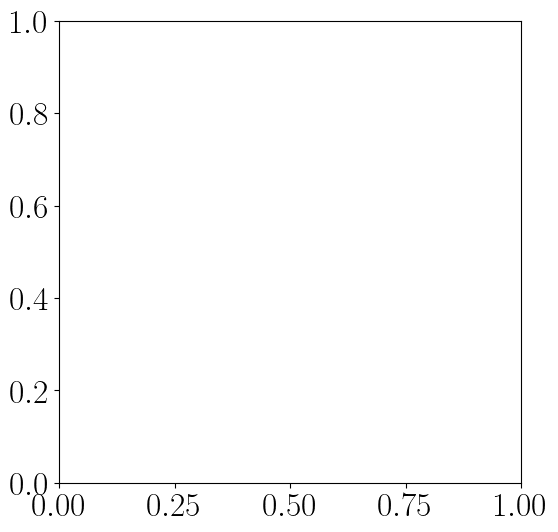

In [8]:
from z2hex.plotting import local_observable_plot

local_observable_plot(jobs[0][0], lattice)